# Ensemble Learning and Random Forests-集合学习和随机森林

假设你向成千上万个随机人提出一个复杂的问题，然后汇总他们的答案。在许多情况下，你会发现这个汇总的答案比专家的答案更好。这被称为**人群的智慧**。同样，对于一组预测样本，汇总一批预测器的预测结果，往往要好于一个单独的预测器。这一组预测器称为**集成（ensemble）**，这种技术称为**集成学习**，一个集合学习算法称为**集成方法**。

随机森林就是一种集成学习，其中包含了多个决策树。例如，你希望用决策树做一个分类器，每个子树都在训练集不同的随机子集上训练。每个子树都有自己的预测结果，决策树的将所有单个树的预测的预测结果统计，然后选择**最多选票**的类别（参见第6章的最后一个练习）。这样的决策树集合被称为随机森林，尽管它很简单，但它是当今最强大的机器学习算法之一。

而且，正如我们在第2章中讨论的那样，一旦你已经构建了一些好的预测器，你就会经常在项目使用Ensemble方法，将它们组合成一个更好的预测器。 事实上，机器学习竞赛中获胜的解决方案通常涉及多种Ensemble方法（最着名的是Netflix奖竞赛）。

在本章中，我们除了讨论随机森林，也将讨论最流行的集成方法，包括bagging, boosting, stacking等。

## Setup

In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
# 让笔记全程输入稳定
np.random.seed(42)

# To plot pretty figures
# 导入绘图工具
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# 设定图片保存路径，这里写了一个函数，后面直接调用即可
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "07_Ensemble Learning and Random Forests"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# 忽略无用警告
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Voting Classifiers-投票分类器

假设我们已经训练了一些分类器，每个分类器的准确率达到约80％。你可能有一个Logistic回归分类器，一个SVM分类器，一个随机森林分类器，K-Nearest Neighbors分类器，也许还有一些别的（见下图）

图7-1.

创建一个更好的分类器的一种非常简单的方法是聚合每个分类器的预测结果并**选择获得最多选票的类作为预测结果**。这种多数表决分类器称为硬投票分类器（见下图）。

图7-2

令人惊讶的是，这种投票分类器通常比集合中的最佳分类器具有更高的准确度。事实上，即使每个分类器都是弱学习者（意味着它只比随机猜测稍微好一些），整体仍然可以成为一个强大的学习者（达到高准确度），只要有足够数量的弱学习者并且他们足够多样化。

这怎么可能？ 以下类比可以帮助揭示这个谜团。假设你有一个稍微有偏见的硬币，有51％的机会出现正面，并有49％的机会出现反面。如果你扔1000次（1000个训练样本），你通常会得到或多或少510正和490反，因此大多数是正。如果你有10多个这样的硬币（10个预测器），每个都扔1000次，我相信大多数硬币出现正面的次数会更多。如果你有10,000个这样的硬币，我们每个抛100次，正面出现多的硬币数量/硬币总数 将接近于97%（集成学习的预测准确率将达到97%）。 

这是由于大数定律：当你不停地掷硬币时，正面的比例越来越接近51％。图7-3显示了10种偏见硬币投掷。你可以看到，随着投掷次数的增加，正面的比例接近51％。 最终所有10个硬币正面朝上的比例接近51％，并且一直高于50％。

图7-3

看着非常直观吧，本身只是准确率仅仅为51%的弱分类器，10000多个联合在一起竟然也可以实现准确率为97%的强分类器，可以说是非常amazing了！但是，这里有个前提，即每个分类器必须**完全独立**，才可以达到理论的最高水平。换言之，我们希望不同的分类器有不同的关注点，从不同的角度分类数据。使用**完全不同的算法**训练数据是一种有效的集成学习方法，这增加了他们制造完全不同类型错误的机会，从而提高了整体的准确性。

以下代码在Scikit-Learn中创建并训练投票分类器，包含三种不同的分类器（训练集是moons dataset，在第5章介绍过的）：


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',...
                                        

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.888
VotingClassifier 0.896


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will 

投票分类器略微优于所有单独的分类器。

如果所有分类器都能够估计类概率（即，他们有一个predict_proba（）方法），那么你可以告诉Scikit-Learn预测具有最高等级概率的类，对所有单个分类器进行平均。这称为软投票。 它通常比硬投票获得更高的性能，因为它给予高度自信的投票更多的权重。你需要做的就是用voting =“soft”替换voting =“hard”，并确保所有分类器都可以估计类概率。默认情况下，SVC类不是估计概率，因此需要将其概率超参数设置为True （这将使SVC类使用交叉验证来估计类概率，减慢训练，并且它将添加predict_proba（）方法）。如果修改前面的代码以使用软投票，您会发现投票分类器的准确率达到91％以上！

## Bagging and Pasting 
正如刚才所讲，集成学习效果好的前提是每个预测器是**独立**的。但是这是有缺陷的，我们未必能找到这么多独立的预测器，如何在数量有限的预测器中，完成我们的集成学习呢？
答案是**用训练集的子集训练每个预测器**。
如果一个训练集能分出 n 个训练子集，每个预测器在这 n 个子集都完成了训练，那么意味着预测器的数量翻了 n 倍。我们通过这种方式增加了预测器的数量，解决了集成学习预测器数量不足的问题。
可以通过下图进一步理解这种思想。

图7-1

那么如何分数据就是我们需要考虑的了。有以下两种思路可供选择：Bagging和Pasting。
* Bagging：有放回采样
* Pasting：无放回采样

举个例子：500个数据样本，计划每个子集为100个。
Bagging先随机拿出100个样本，训练现有的预测器（有SVM，逻辑回归器等等），训练完事儿后，将这100个样本再丢回原先的数据集，再次抽取100个随机样本。
Pasting则拿出100个样本，训练完事儿后，再从剩下的400个训练样本中抽取。

### 7.2.1  Bagging and Pasting in Scikit-Learn
Scikit-Learn提供了一个简单的API使用BaggingClassifier类（或 BaggingRegressor 进行回归）进行Bagging and Pasting。以下代码训练500个决策树分类器的集合。如果你想使用Pasting，只需设置bootstrap = False。

参数 n_jobs告诉Scikit-Learn用于训练和预测的CPU核心数（ -1 告诉Scikit-Learn使用所有可用核心）

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),#  基类预测器
    n_estimators = 500,
    max_samples = 100, 
    bootstrap = True,
    n_jobs = -1,
    random_state=42
)

In [6]:
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [9]:

from matplotlib.colors import ListedColormap
import numpy as np
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

decision_tree_without_and_with_bagging_plot


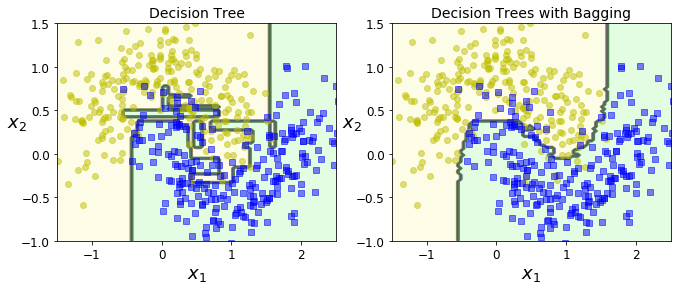

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
print("decision_tree_without_and_with_bagging_plot")
plt.show()

左图是一个决策树的决策边界（显然有点过拟合对吧），右边是使用500棵决策树的Bagging集合的决策边界（很圆润的边界）。如果我们进一步描述的话，可以认为集成学习的结果**方差较小**从而使整体决策边界很“圆润”。原因是因为？？？？

### Out-of-Bag Evaluation
对于任何给定的预测器，有些实例可能会被采样而其他实例可能根本没有被抽中。未采样的训练实例称为out-of-bag (oob)实例。

由于预测器在训练期间从不会看到 oob 实例，因此可以在这些实例上进行评估，无需单独的验证集或交叉验证。你可以通过平均每个预测器的 oob 评估来评估整体本身。

在Scikit-Learn中，你可以在创建BaggingClassifier时设置oob_score = True要求在训练后进行自动oob评估。 以下代码演示了这一点。最终的评估分数可通过oob_score_变量获得：

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),#  基类预测器
    n_estimators=500,
    bootstrap = True,
    n_jobs = -1,
    oob_score=True,
    random_state=40
)

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9013333333333333

根据这个oob评估，BaggingClassifier可能在测试集上达到约91.2％的准确度。 我们来验证一下：

In [12]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.912

每个训练实例的oob决策特征也可以通过oob_decision_function_变量获得。在这种情况下（由于基类估计器具有predict_proba（）方法），决策函数返回每个训练实例的类概率。例如，oob评估估计第二个训练实例有65.89％属于positive class的概率（和属于negative class的34.11％）：

In [13]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

## Random Patches and Random Subspaces
对训练实例和特征进行采样称为Random Patches。
对特征采样被称为随机子空间方法。

采样特征导致预测器更多的多样性。

## Random Forests
正如我们所讨论的，随机森林是决策树的集合，通常通过Bagging方法（或有时Pasting）训练。
您可以改为使用RandomForestClassifier类，而不是构建BaggingClassifier并将其传递给DecisionTreeClassifier，这样更方便并针对Decision Trees 进行了优化 （类似地，有一个RandomForestRegressor类用于回归任务）。以下代码使用所有可用的CPU核心训练具有500棵树（每个限制为最多16个节点）的随机森林分类器：

In [14]:
from sklearn.ensemble import RandomForestClassifier

rdn_clf = RandomForestClassifier
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
y_pred_rf = rnd_clf.predict(X_test)

In [16]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.928

### Extra-Trees
前文提到，在随机森林的基础上，特征也可以随机提取，对每个特征使用随机阈值而不是搜索最佳可能阈值（如常规决策树那样）时，可以使树更加随机。
即**决策树多样 + 数据集随机 + 特征随机**
这种树称为**极端随机树(Extremely Randomized Trees ensemble)** 简称Extra-Trees。这种策略会导致每个决策树之间方差减小，偏差变大。Extra-Trees比常规随机森林更快地训练。

你可以使用Scikit-Learn的ExtraTreesClassifier类创建Extra-Trees分类器。它的API与RandomForestClassifier类相同。同样，Extra TreesRegressor 类与RandomForestRegressor类具有相同的API。

事先很难判断RandomForestClassifier的性能是否比ExtraTreesClassifier更好或更差。通常，要知道的唯一方法是尝试两者并使用交叉验证（同时使用网格搜索调整超参数）来比较它们。


###  Feature Importance
最后，如果你查看一个决策树可能会发现，重要特征可能看起来更接近树的根，而不重要的特征通常会更接近叶子（或根本不显示）。因此，可以通过计算特征在森林中所有树木中出现的平均深度来估计特征的重要性。Scikit-Learn会在训练后自动为每个特征计算。 你可以使用feature_importances_变量访问结果。

例如，以下代码训练鸢尾花数据集上的RandomForestClassifier（在第4章中介绍）并输出每个特征的重要性。似乎最重要的特征是花瓣长度（44％）和宽度（42％），而萼片的长度和宽度相比较不重要（分别为11％和2％）：

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs = -1)
rnd_clf.fit(iris["data"],iris["target"])
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.11189970757963477
sepal width (cm) 0.02222675933160177
petal length (cm) 0.4333470159801416
petal width (cm) 0.43252651710862194


同样，如果你在MNIST数据集上训练随机森林分类器（在第3章中介绍）并绘制每个像素的重要性，得到图7-6中所示的图像。

## Boosting-提升
提升（Boosting，最初称为假设增强）指的是可以将几个弱学习者组合成强学习者的集成方法。对于大多数的提升方法的思想就是按顺序去训练分类器，每一个都要尝试修正前面的分类。现如今已经有很多的提升方法了，但最著名的就是 Adaboost（适应性提升，是 Adaptive Boosting 的简称） 和 Gradient Boosting（梯度提升）。让我们先从 Adaboost 说起。

### AdaBoost
新预测器纠正其前身的一种方法是更多地关注之前的预测器欠拟合的训练实例。 这导致新的预测器越来越关注**比较难的实例**。这是AdaBoost使用的技术。

举个例子，去构建一个 Adaboost 分类器，先训练第一个基类分类器（例如一个决策树），然后拿来在训练集上做预测，然后增加错误分类的训练实例的**相对权重**。 使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新权重，以此类推。如图7-7




图7-7

图7-8显示了 moons 数据集上五个连续预测器的决策边界（在此示例中，每个预测器是一个使用RBF内核的高度正则化的SVM分类器）。 第一个分类器导致许多实例错误，所以他们的权重得到提升。 因此，第二个分类器在这些实例上做得更好，直到第5个可以准确划分。

右边的图表代表了相同的预测器序列，但学习率减半。正如你所看到的，这种顺序学习技术与Gradient Descent有一些相似之处，AdaBoost为整体增加了预测器，逐渐使其变得更好。




图7-8

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

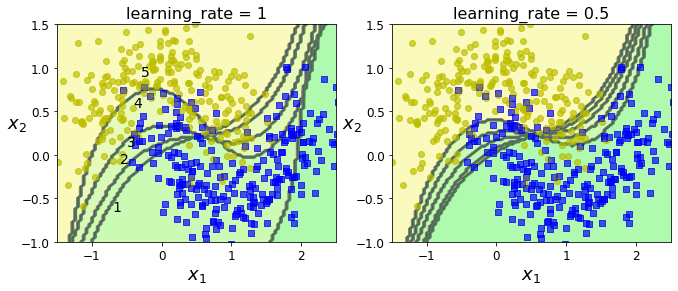

In [18]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

以下代码使用Scikit-Learn的**AdaBoostClassifier**类训练基于200个决策树桩的AdaBoost分类器（正如你所料，还有一个AdaBoostRegressor类）。决策树桩是具有max_depth = 1的决策树 ——换句话说，是由单个决策节点加上两个叶节点组成的树。 这是AdaBoostClassifier类的默认基类估算器：



In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R", 
    learning_rate=0.5, 
    random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

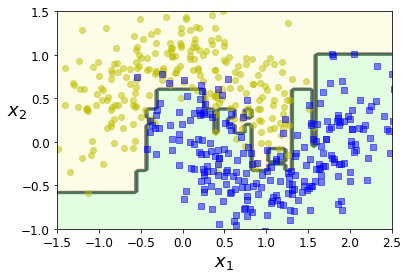

In [20]:
plot_decision_boundary(ada_clf, X, y)

如果你的AdaBoost集合过拟合训练集，您可以尝试减少估算器的数量，或者强调更正则化的预测器。

### Gradient Boosting
另一个非常流行的Boosting算法是**Gradient Boosting**。就像AdaBoost一样，Gradient Boosting通过在一个集合中**依次添加预测器来进行工作，每一个都纠正它的前任**。 但是，这种方法不是像AdaBoost那样在每次迭代时调整实例权重，而是**尝试将新预测器拟合到先前预测器所产生的残差**。


让我们通过一个简单的回归示例，使用决策树作为基础预测器（当然，梯度提升也适用于回归任务）。 这称为渐变树增强（Gradient Tree Boosting）或渐变增强回归树（Gradient Boosted Regression Trees）（GBRT）。 首先，让DecisionTreeRegressor拟合训练集（例如，嘈杂的二次训练集）

In [21]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)


In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth= 2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


现在训练第二个DecisionTreeRegressor来解决第一个预测器遗留的残差：

In [23]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

然后我们训练第三个DecisionTreeRegressor来处理第二个预测器产生的残差：

In [24]:

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

现在我们有一个包含三棵树的集合。它可以简单地通过累加所有树的预测来对新实例进行预测：

In [25]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

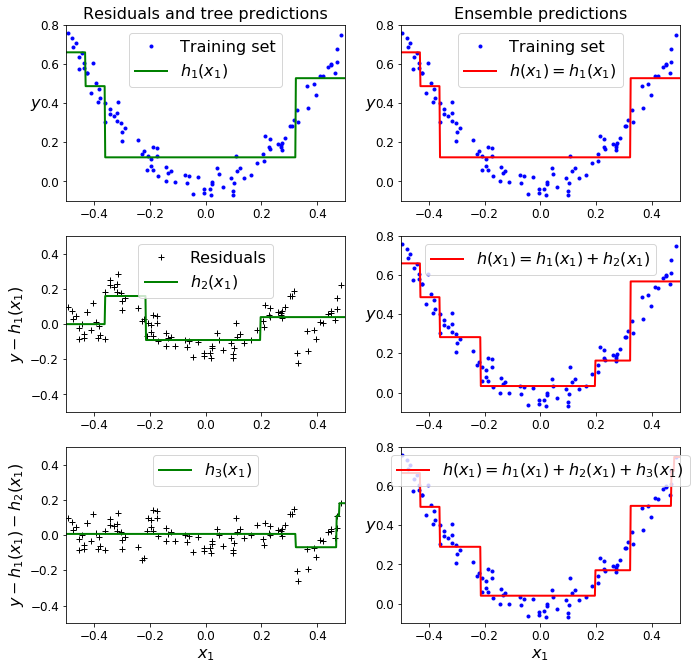

In [26]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)


plt.show()

图7-9（即上图）表示左列中这三棵树的预测，以及右栏中集合的预测。

* 在第一行中，集合只有一棵树，因此它的预测与第一棵树的预测完全相同。

* 在第二行中，对第一棵树的残差错误训练新树。在右侧，你可以看到集合的预测等于前两棵树的预测总和。

* 类似地，在第三行中，对第二树的残留错误训练另一棵树。你可以看到，随着树木被添加到整体中，集合的预测逐渐变得更好。

训练GBRT集合的一种更简单的方法是使用Scikit-Learn的GradientBoostingRegressor类。与RandomForestRegressor类非常相似，它具有：

* 控制决策树增长的超参数（例如，max_depth，min_samples_leaf等），

* 控制集合训练的超参数，例如树的数量（n_estimators）。以下代码创建与前一个相同的集合：



In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=1.0, 
    random_state=42
)

gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


learning_rate超参数缩放每棵树的贡献。如果将其设置为较低的值，例如0.1，你需要更多的树木才能适应训练集，但预测通常会更好地概括。 这是一种称为shrinkage的正则化技术。

In [28]:
gbrt_slow_1 = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=0.1, 
    random_state=42
)

gbrt_slow_1.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
gbrt_slow_2 = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42
)

gbrt_slow_2.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

NameError: name 'gbrt_slow' is not defined

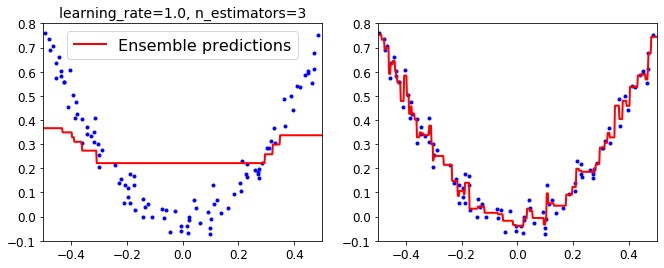

In [30]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt_slow_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)


plt.show()

图7-10（即上图）显示了以低学习率训练的两个GBRT集合：左边的那个没有足够的树来拟合训练集，而右边的那个有太多的树并且过拟合训练集。

####  Gradient Boosting with Early stopping
为了找到最佳树木数量，您可以使用提前停止-**Early stopping**（见第4章）。 实现这一点的一种简单方法是使用staged_predict（）方法：它返回一个迭代器，该迭代器覆盖整个训练阶段的集合所做的预测（有一棵树，两棵树等）。

以下代码训练带有120棵树的GBRT集合，然后测量每个训练阶段的**验证误差**以找到最佳树木数量，最后使用最佳树木数量训练另一个GBRT集合：

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:

min_error = np.min(errors)
print(min_error)

0.002712853325235463


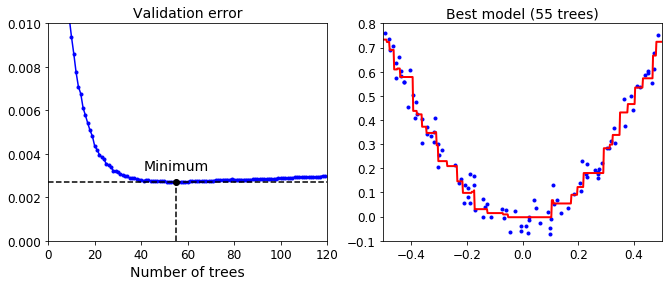

In [33]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)


plt.show()

验证错误显示在图7-11的左侧，最佳模型的预测显示在右侧。

实际中也可以通过早期停止训练来实现早期停止（而不是先培养大量树木，然后回头寻找最佳数量）。你可以通过设置warm_start = True来实现，这使得Scikit-Learn在调用fit（）方法时保留现有树，从而允许增量训练。 当验证错误连续五次迭代没有改进时，以下代码停止训练：

In [34]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
            


In [35]:
print(gbrt.n_estimators)

61


In [36]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**GradientBoostingRegressor**类还支持子样本超参数，它指定用于训练每棵树的**训练实例的百分数**。例如，如果subsample = 0.25，则每个树在25％的训练实例上进行训练，随机选择。 正如你现在可能猜到的那样，**对于较低的方差，这会产生较高的偏差**。 它还大大加快了训练速度。 这种技术称为**随机梯度增强**（Stochastic Gradient Boosting）。

可以使用Gradient Boosting和其他成本函数。这由损失超参数控制（有关详细信息，请参阅Scikit-Learn的文档）。

## Stacking
我们在本章讨论的最后一个Ensemble方法称为**堆叠**（叠加泛化的简称）。它基于一个简单的想法：为什么我们不**训练模型**来执行这种聚合？而不是使用简单的函数（如硬投票）来聚合集合中所有预测器的预测， 图7-12显示了这样一个集合在新实例上执行回归任务。
* 底部三个预测变量中的每一个预测不同的值（3.1,2.7和2.9），

* 然后最终预测器（称为混合器或元学习器--blender, or a meta learner）将这些预测作为输入并进行最终预测（3.0）。

为了训练混合器或元学习器，一种常见的方法是使用hold-out set。让我们看看它是如何工作的。

首先，训练集分为两个子集。 第一个子集用于训练第一层中的预测器（有三个）（见图7-13）。

接下来，第一层预测器被用于在第二个子集进行预测（hold-out）（见图7-14）。 这可以确保预测“干净”，因为预测器在训练期间从未见过这些实例。

现在，对于 hold-out 集中的每个实例，有三个预测值。 我们可以使用这些预测值作为输入特征（这使得这个新的训练集为三维）创建一个新的训练集，并保持目标值。 混合器或元学习器在这个新的训练集上训练，因此它基于第一层的预测结果，学习预测目标值。


实际上可以用这种方式训练几种不同的搅拌器（例如，一个使用线性回归，另一个使用随机森林回归，等等）：我们得到一整层搅拌器。 诀窍是将训练集分成三个子集：

* 第一个用于训练第一层，
* 第二个用于创建用于训练第二层的训练集（使用由第一层的预测器做出的预测）
* 第三个用于创建训练集以训练第三层（使用第二层预测器的预测）。
完成此操作后，我们可以按顺序遍历每个层来预测新实例，如图7-15所示。


不幸的是，Scikit-Learn不支持直接堆叠，但是推出自己的实现并不太难（参见以下练习）。 或者，你可以使用Brew等开源实现 （可在[https://github.com/viisar/brew] 获得）。

值得注意的是，可以使用Gradient Boosting的优化实现在流行的**python库XGBoost**中，该库代表Extreme Gradient Boosting。

此软件包最初是由Tianqi Chen作为Distributed（Deep）的一部分开发的机器学习社区（DMLC），旨在实现极快，可扩展的
和便携式。 实际上，XGBoost通常是获胜的重要组成部分ML竞赛中的参赛作品。 XGBoost的API与Scikit-Learn的API非常相似：



In [37]:
! pip install xgboost

  ERROR: Could not find a version that satisfies the requirement xgboot (from versions: none)
ERROR: No matching distribution found for xgboot


In [38]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [39]:

if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

Validation MSE: 0.00400040950714611


In [40]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], 
                early_stopping_rounds=2
               )
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [41]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

17.9 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

11.8 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
